In [1]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/OSSE_generator/requierements.ipynb

# For 1 month (step by step)

## Loading SSH and dac for january

In [2]:
dataset_ssh = xr.open_dataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/CALEDO60-TRPC12NT0_y2014m01d01-d31.1h_SSH.nc")
dataset_dac = xr.open_dataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/DAC_limpio/dac_cropped_1h_SSHgrid_01.nc")

## Dropping and renaming the time variable

In [3]:
dataset_dac = dataset_dac.drop("time_counter") # Droping the time_counter variable
dataset_dac= dataset_dac.rename({'time': 'time_counter'}) # Renaming the time variable to time_counter

## Loading into memory

In [4]:
ssh_01 = dataset_ssh.zos.load() # Loading the variable zos 
dac_01 = dataset_dac.dac.load() # Loading the variable dac

## Performing the susbtraction

In [5]:
dataset_ssh["ssh_dedac"] = ssh_01 - dac_01

## Getting rid off unecessary variables

In [6]:
dataset_ssh = dataset_ssh.drop(["zos", "time_counter_bounds", "time_instant_bounds", "time_instant"]) 

In [7]:
dataset_ssh

<xarray.Dataset>
Dimensions:       (y: 853, x: 788, time_counter: 744)
Coordinates:
    nav_lat       (y, x) float32 -28.8 -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    nav_lon       (y, x) float32 159.2 159.2 159.3 159.3 ... 172.3 172.3 172.3
  * time_counter  (time_counter) datetime64[ns] 2014-01-01T00:30:00 ... 2014-...
    latitude      (y, x) float32 -28.8 -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    longitude     (y, x) float32 159.2 159.2 159.3 159.3 ... 172.3 172.3 172.3
Dimensions without coordinates: y, x
Data variables:
    ssh_dedac     (time_counter, y, x) float64 0.03277 0.03273 ... -0.03466
Attributes:
    name:         1_/scratch/cnt0024/ige2071/brodeau/NEMO/TROPICO12/TROPICO12...
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2021-Jul-30 09:28:08 GMT
    uuid:         dfea4106-852e-44e9-a456-80ebfbca9f95
    history:      Fri Feb  2 16:39:45 2024: /lus/home/CT1/ige2071/aalbert/.co...
    NCO:          netCDF Operators version 5.1.4 (Homepage = http://nco.sf.ne...

## Apply the mask

In [8]:
mask = xr.open_dataset('/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc',drop_variables={"x","y"}) 

In [9]:
ssh_dedac_masked = dataset_ssh['ssh_dedac'].where(mask.tmaskutil[0,:,:] == 1).load() # Masking the variable ssh_dedac

## Saving the final output

In [ ]:
dataset_ssh.to_netcdf("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/ssh_dedac_01.nc")

## Plotting to see a difference (?)

In [10]:
ssh = xr.open_dataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/CALEDO60-TRPC12NT0_y2014m01d01-d31.1h_SSH.nc")

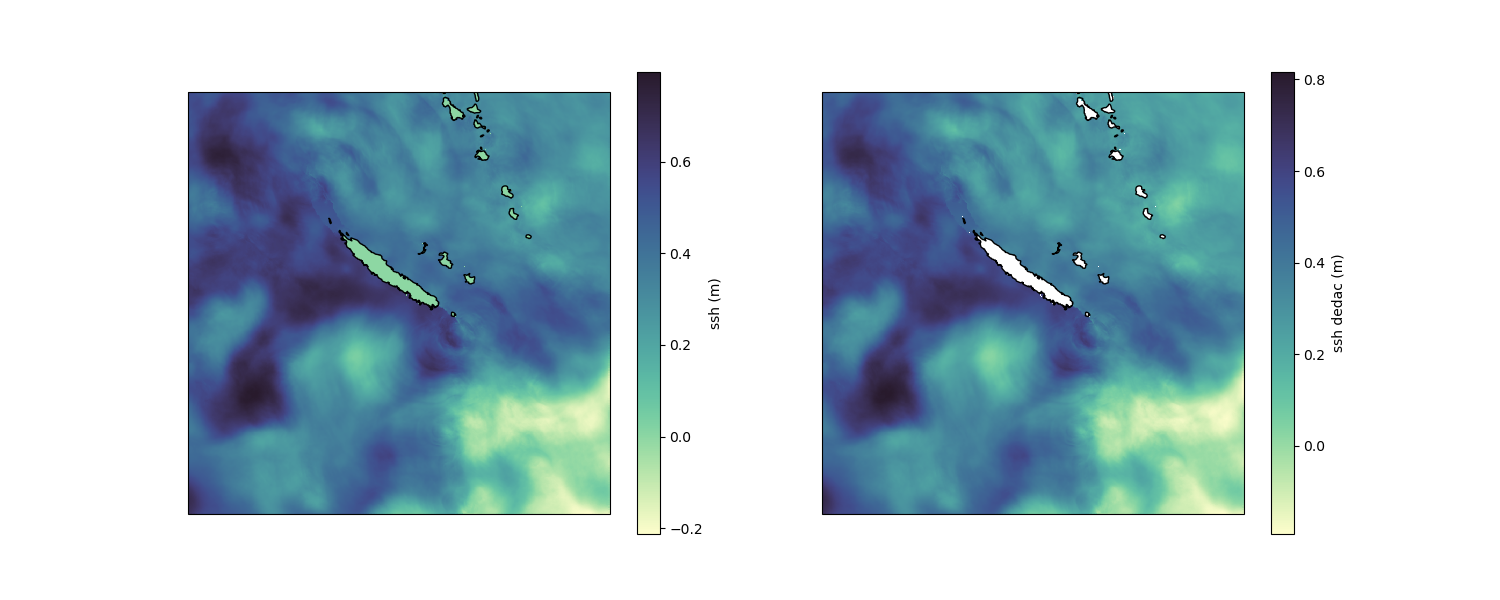

In [12]:
# Define the projection
projection = ccrs.PlateCarree()

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': projection})

# Define the geographic domain
lon_min, lon_max = 159.23333740234375, 172.34999084472656
lat_min, lat_max = -28.803945541381836, -15.699763298034668

# Loop through each subplot to set up the plot
for ax in axs:
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.coastlines('10m', edgecolor='black', linewidth=1)
    #ax.set_title('SSH on 2014-01-01 00:00')

# Plot the first dataset on the left subplot
latitude = ssh.nav_lat.values
longitude = ssh.nav_lon.values

# Select the first time step for the ssh data
dac_data = ssh['zos'][0, :, :].values
dac_plot = axs[0].pcolormesh(longitude, latitude, dac_data, transform=ccrs.PlateCarree(), cmap=cmocean.cm.deep)
fig.colorbar(dac_plot, ax=axs[0], orientation='vertical', label='ssh (m)')

# Plot the second dataset on the right subplot
# Assuming ssh_dedac_masked has the same coordinate names as ssh
# Select the first time step for the ssh_dedac_masked data
dac_data_dedac = ssh_dedac_masked[0, :, :].values
dac_plot_dedac = axs[1].pcolormesh(longitude, latitude, dac_data_dedac, transform=ccrs.PlateCarree(), cmap=cmocean.cm.deep)
fig.colorbar(dac_plot_dedac, ax=axs[1], orientation='vertical', label='ssh dedac (m)')

plt.show()


# Loop for the rest of the months

In [ ]:
import xarray as xr
import os
from calendar import monthrange

# Base paths for the datasets
base_path_ssh = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60"
base_path_dac = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/DAC_limpio"
mask_path = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc"
save_path = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60_dedac"
# The year you are processing
year = 2014

# Load the mask (since it's the same for all months)
mask = xr.open_dataset(mask_path, drop_variables={"x", "y"})

for month in range(1, 13):  # For each month
    # Get the correct number of days in the month
    days_in_month = monthrange(year, month)[1]
    
    ssh_pattern = f"CALEDO60-TRPC12NT0_y{year}m{month:02d}d01-d{days_in_month}.1h_SSH.nc"
    dac_pattern = "dac_cropped_1h_SSHgrid_{:02d}.nc".format(month)

    ssh_file = os.path.join(base_path_ssh, ssh_pattern)
    dac_file = os.path.join(base_path_dac, dac_pattern)
    
    # Load the datasets
    dataset_ssh = xr.open_dataset(ssh_file)
    dataset_dac = xr.open_dataset(dac_file)
    
    # Process DAC dataset
    dataset_dac = dataset_dac.drop("time_counter")
    dataset_dac = dataset_dac.rename({'time': 'time_counter'})
    
    # Load the data
    ssh_data = dataset_ssh.zos.load()
    dac_data = dataset_dac.dac.load()
    
    # Subtract dac from ssh
    dataset_ssh["ssh_dedac"] = ssh_data - dac_data
    
    # Drop unnecessary variables
    dataset_ssh = dataset_ssh.drop(["zos", "time_counter_bounds", "time_instant_bounds", "time_instant"])
    
    # Apply the mask
    ssh_dedac_masked = dataset_ssh['ssh_dedac'].where(mask.tmaskutil[0,:,:] == 1).load()
    
    # Save the result
    output_file = os.path.join(save_path, f"ssh_dedac_masked_{month:02d}.nc")
    ssh_dedac_masked.to_netcdf(output_file)
    
    # Close the datasets to free up resources
    dataset_ssh.close()
    dataset_dac.close()

    print(f"Processed and saved month {month:02d}")
